<a href="https://colab.research.google.com/github/vladargunov/msai_devops_hw/blob/master/Devops_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
!pip install bs4 -qqq
import requests
import bs4
import pandas as pd
from IPython.display import Image, display
from tqdm import tqdm
import base64

  Preparing metadata (setup.py) ... done


# Construct CountryScraper

Country Scraper is intended to collect data from Wikiperdia website about the country's name, capital, area, and population.

Each method of such class is self explanatory and is later used to construct final datatable. See example after the instantiation of the class.

In [3]:
class CountryScraper:
    def __init__(self):
        # Get list of all countries
        self.all_countries_list = self.get_all_available_countries()

    def get_all_available_countries(self):
        all_countries_link = (
            "https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_area"
        )
        html_page = bs4.BeautifulSoup(
            requests.get(all_countries_link).content, "html.parser"
        )
        all_links = list(html_page.find_all("a"))

        all_countries_list = []
        # Introduce two flags about Russia and Vatican, as first and last countries
        russia_appeared = False
        vatican_appeared = False
        for link in all_links:
            try:
                if "/wiki/" in link.get("href"):
                    # Append only between Russia and Vatican
                    country_name = link.get("title")
                    if country_name == "Russia":
                        russia_appeared = True
                    elif country_name == "Vatican City":
                        vatican_appeared = True
                    # Add country to the list
                    if russia_appeared:
                        all_countries_list.append(country_name)
                    if vatican_appeared:
                        break

            except TypeError:
                print(f"Error occured here: {link}")

        return all_countries_list

    def get_flag_link_of_country(self, country: str):
        base_link = "https://upload.wikimedia.org/wikipedia/"
        search_link = f"https://en.wikipedia.org/wiki/Flag_of_{country}#/media/File:Flag_of_{country}.svg"

        response = bs4.BeautifulSoup(requests.get(search_link).content, "html.parser")
        list_response = str(response.contents).split("\n")

        for row in list_response:
            if base_link in row:
                # Find indices of start and end links in row
                start_id = row.find(base_link)
                end_id = row.find(f".svg.png")

                img_link = row[start_id : (end_id + len(".svg.png"))]

                return img_link

        raise FileNotFoundError(f"Image of country {country} was not found!")

    def display_flag_clountry(self, country):
        flag_link = self.get_flag_link_of_country(country)
        display(Image(flag_link))

    def get_capital_country(self, country):
        country_url = f"https://en.wikipedia.org/wiki/{country}"

        response = bs4.BeautifulSoup(requests.get(country_url).content, "html.parser")

        response = str(response.contents).split("\n")

        for row in response:
            if "Capital" in row:
                capital_string = row[row.find("Capital") :]
                capital_string = capital_string[
                    (capital_string.find("title") + len("title") + 2) :
                ]
                capital_string = capital_string[: capital_string.find(">") - 1]
                return capital_string

        raise FileNotFoundError(f"Capital of country {country} was not found!")

    def get_population_country(self, country: str):
        country_url = f"https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population"

        response = bs4.BeautifulSoup(requests.get(country_url).content, "html.parser")

        response_text = response.text.split("\n")

        # Get population value
        for row_id, row in enumerate(response_text):
            if country in row:
                population = response_text[row_id + 2]
                break

        population = population.strip().replace(",", "")

        population_return = ""
        # Try each subsequent value for case of integer
        for num in population:
            try:
                population_int = int(num)
                population_return += num
            except ValueError:
                break
        return population_return

    def get_area_country(self, country: str):
        country_url = (
            f"https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_area"
        )

        response = bs4.BeautifulSoup(requests.get(country_url).content, "html.parser")

        response_text = response.text.split("\n")

        # Get population value
        for row_id, row in enumerate(response_text):
            if country in row:
                area = response_text[row_id + 1]
                break

        area = area.strip().replace(",", "")

        area_return = ""
        # Try each subsequent value for case of integer
        for num in area:
            try:
                area_int = int(num)
                area_return += num
            except ValueError:
                break
        return area_return

    def get_info_about_country(self, country):
        flag_url = self.get_flag_link_of_country(country)
        capital = self.get_capital_country(country)
        area = self.get_area_country(country)
        population = self.get_population_country(country)

        return {
            "Country": country,
            "Flag Image URL": flag_url,
            "Capital": capital,
            "Area (km^2)": area,
            "Population": population,
        }

    def construct_table(self, selected_countries=None):
        data_rows = []
        iterator_countries = (
            self.all_countries_list
            if selected_countries is None
            else selected_countries
        )
        for country in tqdm(iterator_countries):
            try:
                data_row = self.get_info_about_country(country)
                data_rows.append(data_row)
            except Exception as e:
                print(f"Error in retrieving data from country {country}")

        # Save table as a variable
        self.dataset = pd.DataFrame(data_rows)
        return pd.DataFrame(data_rows)


## Example

Here I construct a simple table of data from all the countries liste in wikipedia. Note, however, that some of the countries were not able to be parsed since they do not contain part of the required data. However, 280 countries were successfully parsed.

In [4]:
cs = CountryScraper()

In [ ]:
data = cs.construct_table()

  1%|          | 2/318 [00:03<07:07,  1.35s/it]

Error in retrieving data from country Antarctica


  4%|▍         | 12/318 [00:32<13:17,  2.61s/it]

Error in retrieving data from country Democratic Republic of the Congo


  4%|▍         | 13/318 [00:32<09:47,  1.93s/it]

Error in retrieving data from country no


  4%|▍         | 14/318 [00:33<07:30,  1.48s/it]

Error in retrieving data from country Danish Realm


  5%|▌         | 16/318 [00:35<06:24,  1.27s/it]

Error in retrieving data from country Danish Realm


 22%|██▏       | 70/318 [02:57<10:33,  2.56s/it]

Error in retrieving data from country Republic of the Congo


 26%|██▋       | 84/318 [03:37<08:57,  2.30s/it]

Error in retrieving data from country Western Sahara


 30%|██▉       | 95/318 [04:02<06:24,  1.73s/it]

Error in retrieving data from country Syria


 40%|███▉      | 127/318 [05:25<08:27,  2.66s/it]

Error in retrieving data from country Republic of Ireland


 40%|████      | 128/318 [05:27<08:14,  2.60s/it]

Error in retrieving data from country Georgia (country)


 42%|████▏     | 132/318 [05:37<07:02,  2.27s/it]

Error in retrieving data from country Svalbard


 53%|█████▎    | 169/318 [07:13<06:05,  2.46s/it]

Error in retrieving data from country The Bahamas


 55%|█████▌    | 175/318 [07:28<05:49,  2.45s/it]

Error in retrieving data from country The Gambia


 57%|█████▋    | 182/318 [07:46<04:42,  2.08s/it]

Error in retrieving data from country Abkhazia


 58%|█████▊    | 185/318 [07:53<04:35,  2.07s/it]

Error in retrieving data from country State of Palestine


 60%|█████▉    | 190/318 [08:04<04:08,  1.94s/it]

Error in retrieving data from country Transnistria


 62%|██████▏   | 196/318 [08:18<03:57,  1.95s/it]

Error in retrieving data from country Republic of Artsakh


 63%|██████▎   | 201/318 [08:29<03:50,  1.97s/it]

Error in retrieving data from country Bir Tawil


 64%|██████▎   | 202/318 [08:30<02:58,  1.54s/it]

Error in retrieving data from country Terra nullius


 65%|██████▌   | 208/318 [08:42<02:58,  1.62s/it]

Error in retrieving data from country Danish Realm


 68%|██████▊   | 217/318 [09:04<04:00,  2.38s/it]

Error in retrieving data from country Federated States of Micronesia


 73%|███████▎  | 232/318 [09:39<02:25,  1.69s/it]

Error in retrieving data from country Heard Island and McDonald Islands


 74%|███████▍  | 235/318 [09:46<02:29,  1.80s/it]

Error in retrieving data from country Jan Mayen


 75%|███████▍  | 237/318 [09:50<02:36,  1.94s/it]

Error in retrieving data from country United States Virgin Islands


 82%|████████▏ | 260/318 [10:49<02:07,  2.19s/it]

Error in retrieving data from country Easter Island


 86%|████████▋ | 275/318 [11:26<01:26,  2.02s/it]

Error in retrieving data from country Bailiwick of Guernsey


 88%|████████▊ | 280/318 [11:38<01:21,  2.15s/it]

Error in retrieving data from country Collectivity of Saint Martin


 89%|████████▉ | 284/318 [11:48<01:17,  2.29s/it]

Error in retrieving data from country Bouvet Island


 94%|█████████▍| 300/318 [12:28<00:34,  1.94s/it]

Error in retrieving data from country United States Minor Outlying Islands


 95%|█████████▌| 303/318 [12:34<00:28,  1.93s/it]

Error in retrieving data from country Saba (island)


 96%|█████████▌| 306/318 [12:40<00:20,  1.71s/it]

Error in retrieving data from country Realm of New Zealand


 97%|█████████▋| 309/318 [12:45<00:14,  1.66s/it]

Error in retrieving data from country Clipperton Island


 98%|█████████▊| 311/318 [12:50<00:12,  1.85s/it]

Error in retrieving data from country Ashmore and Cartier Islands


 98%|█████████▊| 313/318 [12:53<00:07,  1.57s/it]

Error in retrieving data from country Spratly Islands


 99%|█████████▊| 314/318 [12:53<00:05,  1.25s/it]

Error in retrieving data from country Spratly Islands dispute


 99%|█████████▉| 315/318 [12:54<00:03,  1.03s/it]

Error in retrieving data from country Coral Sea Islands


100%|██████████| 318/318 [13:02<00:00,  2.46s/it]


In [ ]:
# Patch of data to remove last two countries since they gave strange results
data = data.iloc[:-2]

The same dataframe is represented in Github repo as a csv file

In [ ]:
data.head()

,Country,Flag Image URL,Capital,Area (km^2),Population
0,Russia,https://upload.wikimedia.org/wikipedia/en/thum...,Moscow,17098246,146424729
1,Canada,https://upload.wikimedia.org/wikipedia/commons...,Ottawa,9984670,40130200
2,China,https://upload.wikimedia.org/wikipedia/commons...,Beijing,9596961,1411750000
3,United States,https://upload.wikimedia.org/wikipedia/en/thum...,"Washington, D.C.",9833517,335038000
4,Brazil,https://upload.wikimedia.org/wikipedia/en/thum...,Brasília,8515767,203062512


You can also display an image of any requested flag of the country.

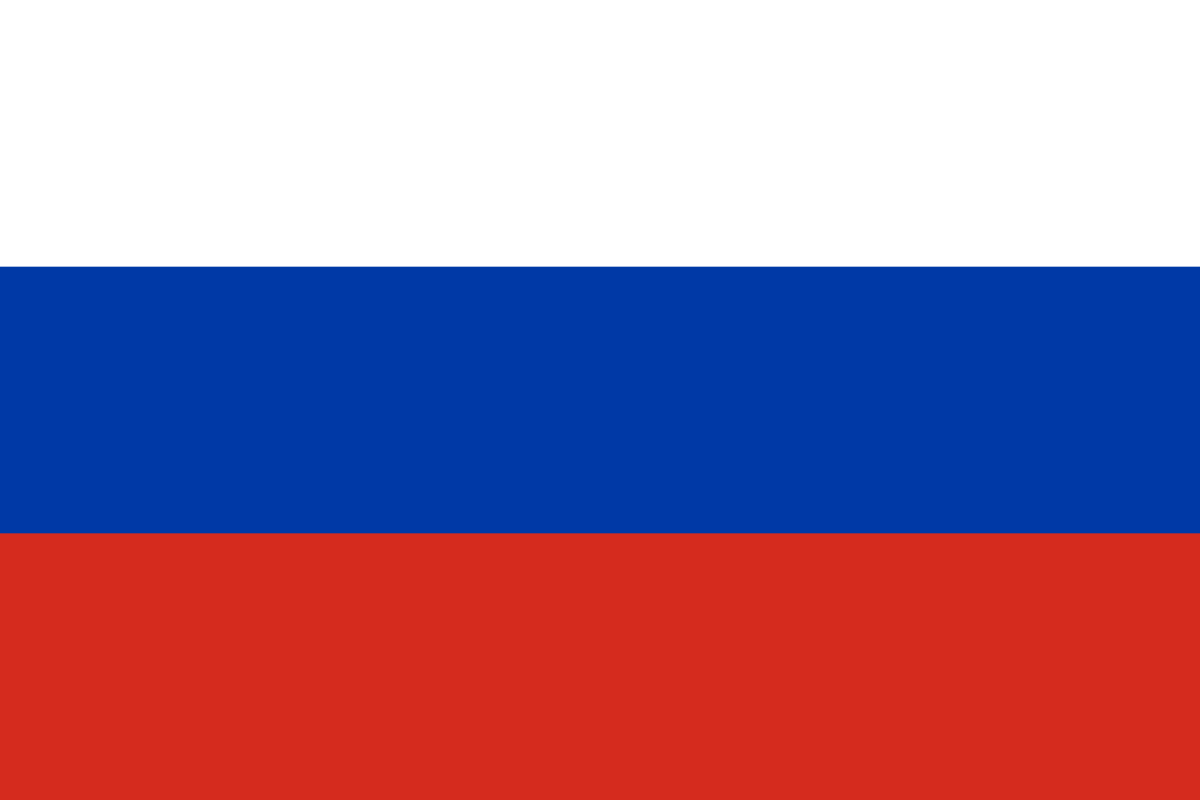

In [ ]:
cs.display_flag_clountry('Russia')

# Extra functionality after the first review:

1. Introduction of the functionality to save images as base64.

2. Introduction of breadth-first algorithm

3. Introduction of depth-first algorithm

In [279]:
class EnhancedCountryScraper(CountryScraper):
    def _upload_dataset_csv(self, path_csv : str):
        self.dataset = pd.read_csv(path_csv)

    def save_flags_base64(self):
        flags_urls = self.dataset["Flag Image URL"].tolist()
        countries = self.dataset["Country"].tolist()
        # for each image request it and save as base64
        base64_strings = []
        for flag_url, country in tqdm(zip(flags_urls, countries)):
            # get base64 string
            try:
                base64_string = base64.b64encode(requests.get(flag_url).content)
            except Exception as e:
                base64_string = None
                print(f"Error occured in converting url to base 64 string for country {country}")

            base64_strings.append(base64_string)

        self.dataset['Flag Image base64'] = base64_strings


    def display_image_from_base64(self, country : str):
        # get base64 string for flag url image
        flag_country_base64 = self.dataset[self.dataset['Country'] == country]['Flag Image base64'].iloc[0]

        # display an image
        display(Image(base64.b64decode(flag_country_base64)))

    def _get_all_images_and_links_page(self, link : str):
        resp = requests.get(link)
        soup = bs4.BeautifulSoup(resp.text, 'html.parser')

        all_images_page = soup.findAll('img')
        all_links = soup.find("div", {"id": "bodyContent"}).findAll('a')

        return all_images_page, all_links, soup

    def _display_all_images_page(self, images_page, limit_num_images):
        num_images_diplayed = 0
        for img in images_page:
            link_image = "https:" + img.get('src')
            try:
                display(Image(link_image))
                # Save image to dir
                num_images_diplayed += 1
            except Exception as e:
                pass

            if num_images_diplayed >= limit_num_images:
                break

        return num_images_diplayed


    def get_image_story_of_country(self, country : str, total_limit_images : int=10,
                                              limit_per_page : int = 10):
        wiki_link = f"https://en.wikipedia.org"
        base_link = f"https://en.wikipedia.org/wiki/{country}"
        parsed_links_set = set()

        all_images_page, all_links, _ = self._get_all_images_and_links_page(base_link)

        links = {f"{idx}" : value for idx, value in enumerate(all_links)}
        parsed_links = {f"{idx}" : False for idx, value in enumerate(all_links)}
        current_idx = "0"
        parsed_links[current_idx] = True
        total_images_displayed = 0
        limit_images_page = 0
        while True:
            # Determine number of images to display per page
            if total_images_displayed + limit_per_page <= total_limit_images:
                num_images_diplayed = self._display_all_images_page(images_page=all_images_page,
                                                                    limit_num_images=limit_per_page)
                total_images_displayed += num_images_diplayed


                # Determine new link to parse
                for parsed_link_key in sorted(parsed_links.keys()):
                    if not parsed_links[parsed_link_key]:
                        parsed_links[parsed_link_key] = True

                        new_link = links[parsed_link_key]

                        current_idx = parsed_link_key
                        # Test all possible conditions for links inconsistency
                        try:
                            if new_link in parsed_links_set:
                                continue
                            else:
                                parsed_links_set.add(new_link)

                            if len(new_link.get('href')) == 0:
                                continue

                            # Do not include .svg links
                            if ".svg" in new_link.get('href'):
                                continue

                            # Exclude # links
                            if "#" in new_link.get('href'):
                                continue

                            if "Wikipedia" in new_link.get('href'):
                                continue
                        except Exception as e:
                            continue

                        if new_link.get('href')[0] != '#':
                            try:
                                new_link = wiki_link + new_link.get('href')
                                all_images_page, new_all_links, _  = self._get_all_images_and_links_page(new_link)
                                break
                            except Exception as e:
                                continue

                # Get next link, if all links are used, then move to the next layer
                new_links = {f"{current_idx}.{idx}" : value for idx, value in enumerate(new_all_links)}
                new_parsed_links = {f"{current_idx}.{idx}" : False for idx, value in enumerate(new_all_links)}
                links = {**links, **new_links}
                parsed_links = {**parsed_links, **new_parsed_links}
            else:
                self._display_all_images_page(images_page=all_images_page, limit_num_images=total_limit_images - total_images_displayed)
                break


### Download previous dataset and enhance it

In [274]:
!wget https://raw.githubusercontent.com/vladargunov/msai_devops_hw/master/data_countries.csv -q

### Add base64 encoded images to the dataset

In [280]:
ecs = EnhancedCountryScraper()
ecs._upload_dataset_csv('/content/data_countries.csv')
ecs.save_flags_base64()

218it [00:18, 14.09it/s]

Error occured in converting url to base 64 string for country Saint Helena, Ascension and Tristan da Cunha


280it [00:23, 11.68it/s]


In [278]:
# Save dataset to file - same file is uploaded to Github
ecs.dataset.to_csv("data_countries_enhanced.csv", index=False)

## Breadth-first search: Get image information about the country

Use the next line of code to parse the links and images from them to represent how country is visualised in Wikipedia

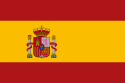

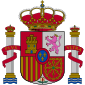

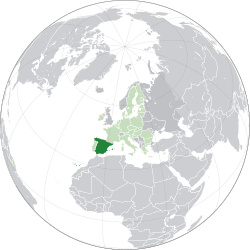

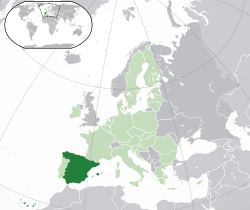

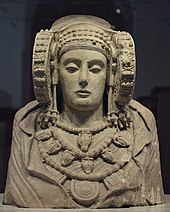

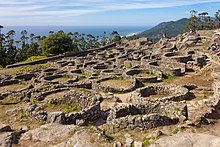

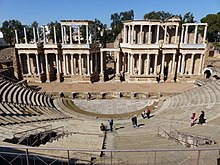

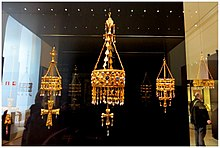

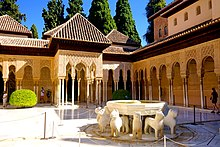

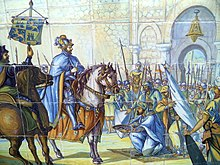

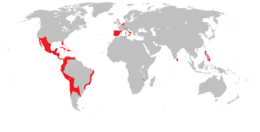

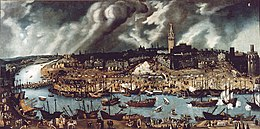

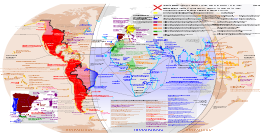

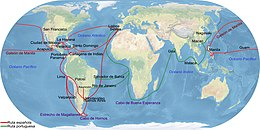

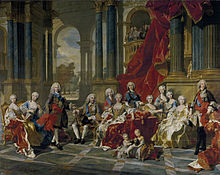

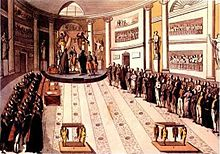

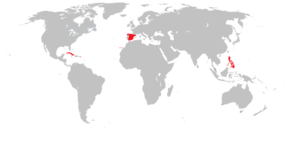

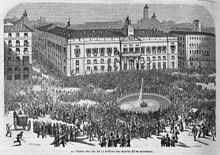

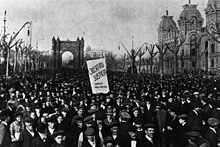

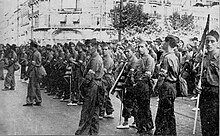

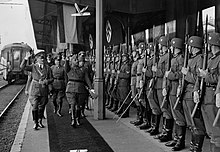

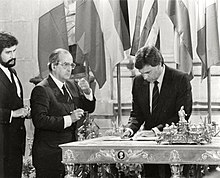

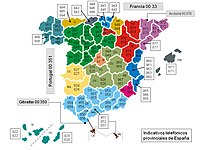

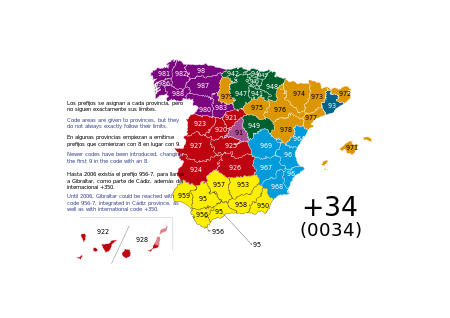

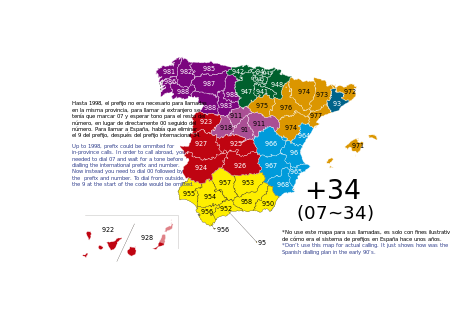

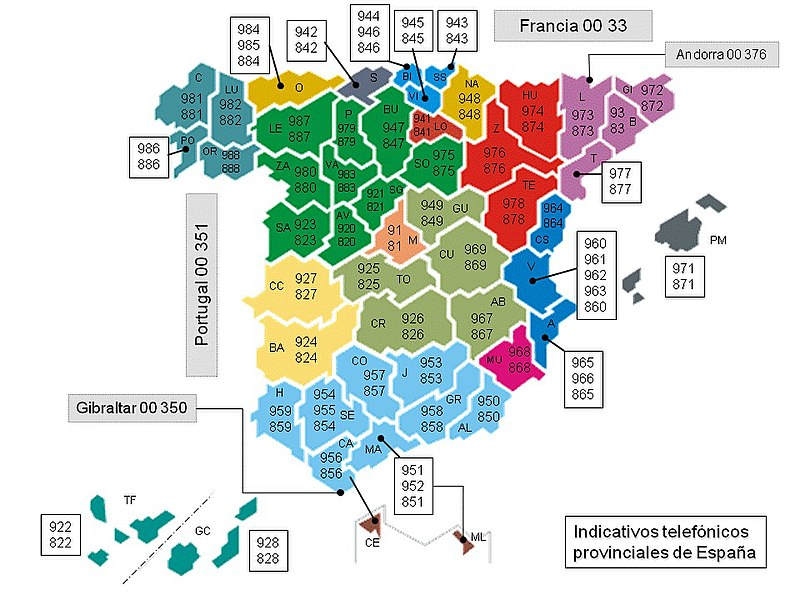

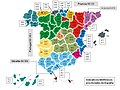

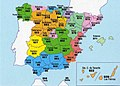

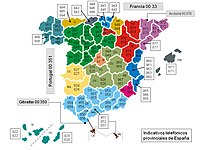

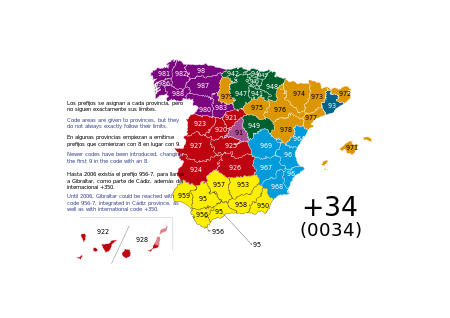

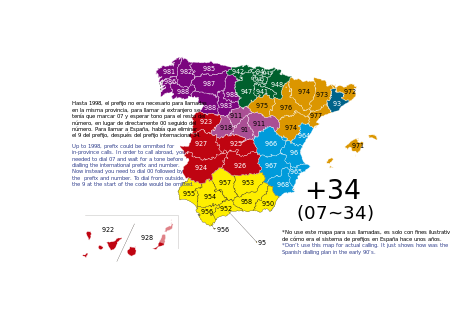

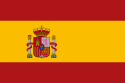

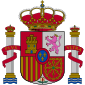

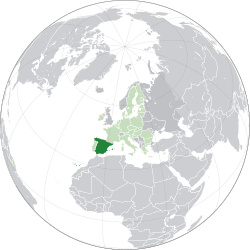

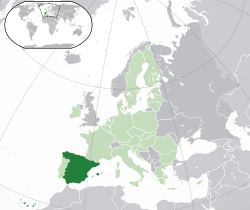

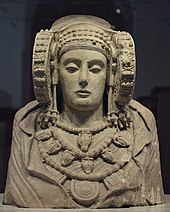

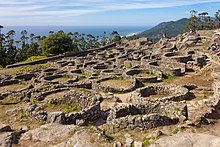

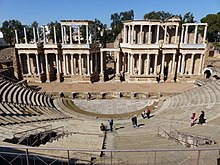

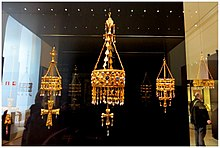

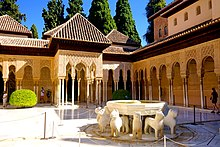

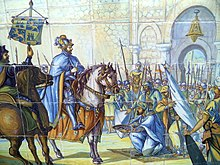

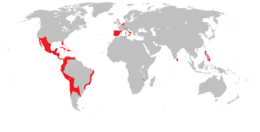

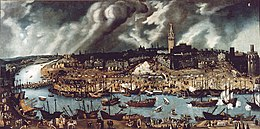

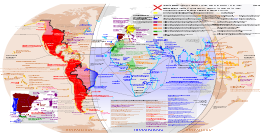

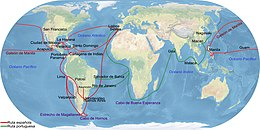

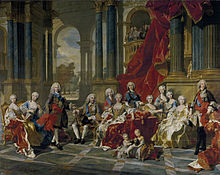

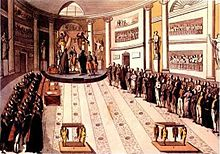

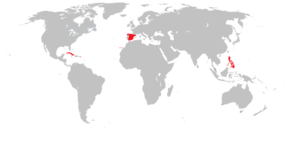

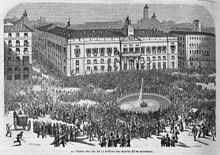

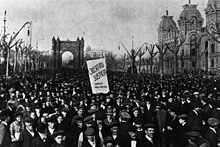

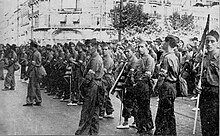

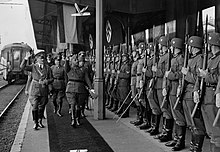

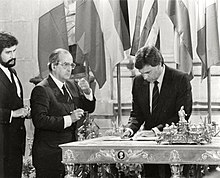

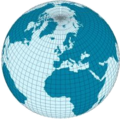

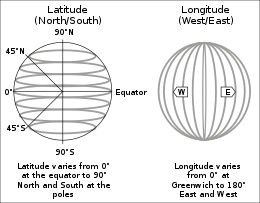

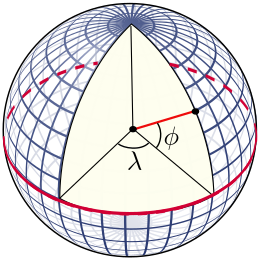

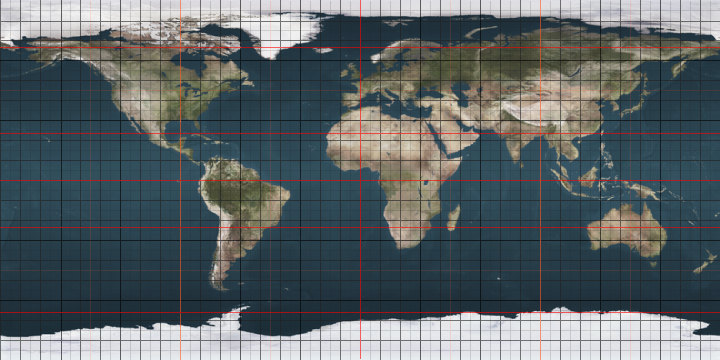

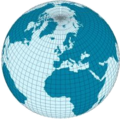

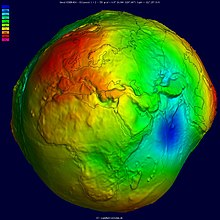

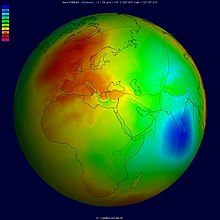

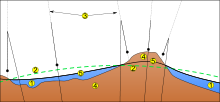

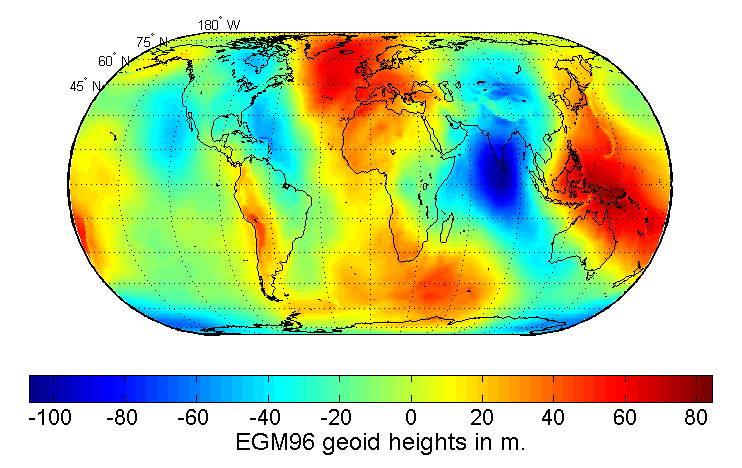

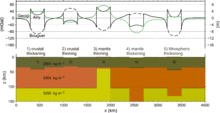

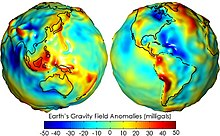

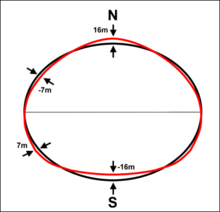

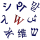

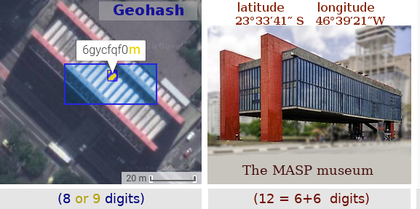

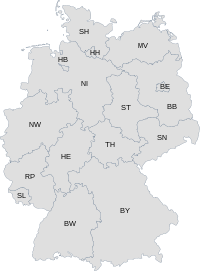

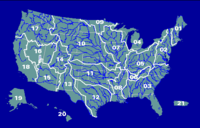

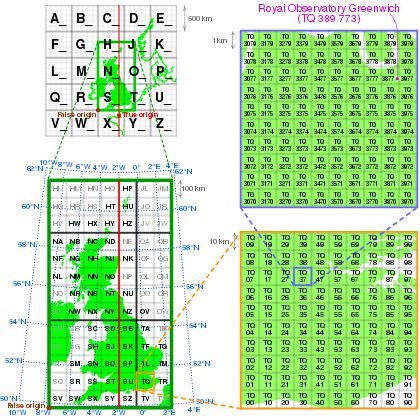

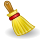

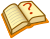

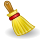

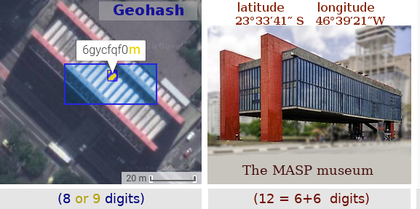

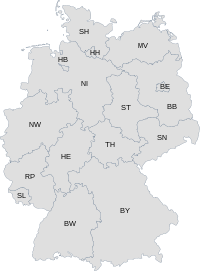

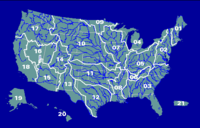

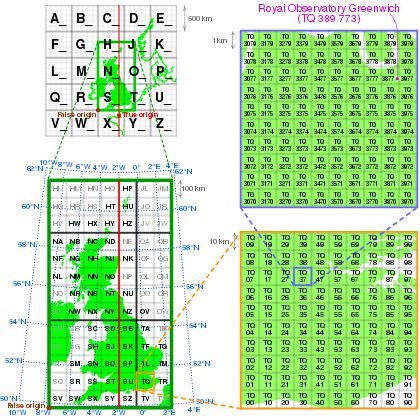

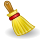

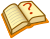

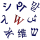

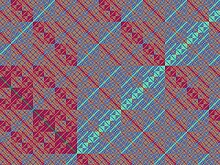

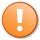

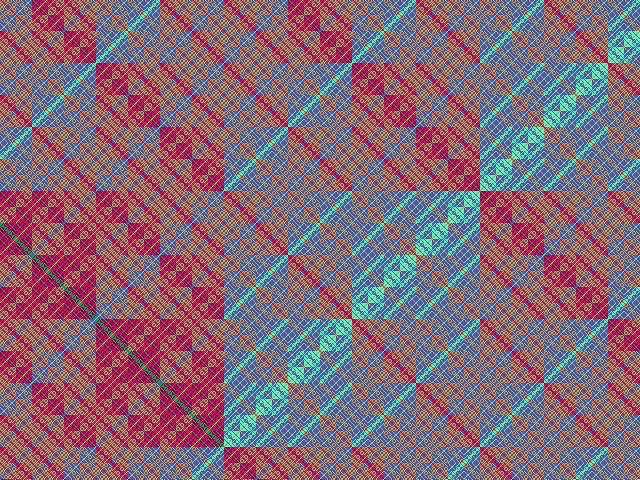

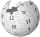

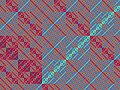

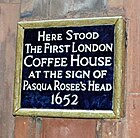

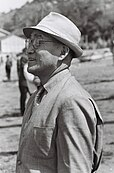

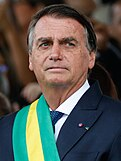

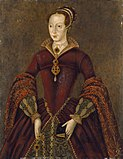

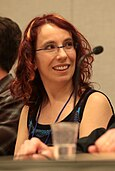

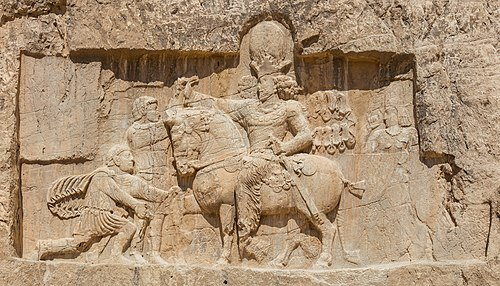

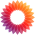

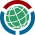

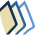

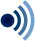

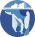

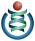

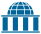

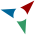

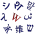

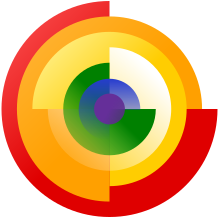

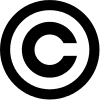

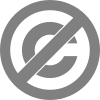

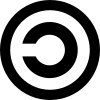

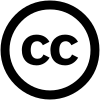

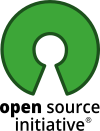

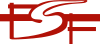

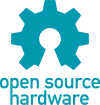

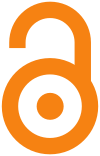

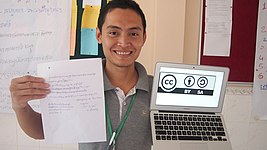

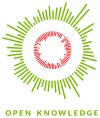

In [283]:
bf = ecs.get_image_story_of_country('Spain', limit_per_page=30, total_limit_images=150)